# The best place for you to live in São Paulo

This notebook presents the code used to solve the business problem I've proposed for IBM Data Science Certificate final project. My proposal was to segment São Paulo apartments avaliable for rent according to some characteristics – more specifically: size, price of rent and price of condominuim, in order to help people to find the best place to live according to the amount of money they can spend on a rent and to some characteristics of the districts where this places are located. Please check the final report to see more details.

First of all, I've imported all libraries and packages necessary

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import geocoder
import requests
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

/usr/lib/python3.8/site-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


My primary data is already avaliable at Kaggle plataform. After download it, I've opened the file with Pandas library to start to explore it

In [2]:
#open file
rent_path = 'properties-april-2019.csv'
rent = pd.read_csv(rent_path)
rent.head()

Price  Condo  Size  Rooms  Toilets  Suites  Parking  Elevator  Furnished  \
0    930    220    47      2        2       1        1         0          0   
1   1000    148    45      2        2       1        1         0          0   
2   1000    100    48      2        2       1        1         0          0   
3   1000    200    48      2        2       1        1         0          0   
4   1300    410    55      2        2       1        1         1          0   

   Swimming Pool  New               District Negotiation Type Property Type  \
0              0    0  Artur Alvim/São Paulo             rent     apartment   
1              0    0  Artur Alvim/São Paulo             rent     apartment   
2              0    0  Artur Alvim/São Paulo             rent     apartment   
3              0    0  Artur Alvim/São Paulo             rent     apartment   
4              0    0  Artur Alvim/São Paulo             rent     apartment   

    Latitude  Longitude  
0 -23.543138 -46.479486  
1 -23.550239 -46.480718  
2 -23.542818 -46.485665  
3 -23.547171 -46.483014  
4 -23.525025 -46.482436

In [3]:
#check for null and missing values
rent.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13640 entries, 0 to 13639
Data columns (total 16 columns):
Price               13640 non-null int64
Condo               13640 non-null int64
Size                13640 non-null int64
Rooms               13640 non-null int64
Toilets             13640 non-null int64
Suites              13640 non-null int64
Parking             13640 non-null int64
Elevator            13640 non-null int64
Furnished           13640 non-null int64
Swimming Pool       13640 non-null int64
New                 13640 non-null int64
District            13640 non-null object
Negotiation Type    13640 non-null object
Property Type       13640 non-null object
Latitude            13640 non-null float64
Longitude           13640 non-null float64
dtypes: float64(2), int64(11), object(3)
memory usage: 1.5+ MB


This data set is very consistent and don't present any null or missing values. After checking it, I've made some adjusts and selected only the rows and columns relevant for my problem. I've worked only with apartments for rent.

In [4]:
#adjust values from district column
rent['District'] = rent['District'].str.split('/').str[0]
rent['District'] = rent['District'] + ', SP'
rent.head()

Price  Condo  Size  Rooms  Toilets  Suites  Parking  Elevator  Furnished  \
0    930    220    47      2        2       1        1         0          0   
1   1000    148    45      2        2       1        1         0          0   
2   1000    100    48      2        2       1        1         0          0   
3   1000    200    48      2        2       1        1         0          0   
4   1300    410    55      2        2       1        1         1          0   

   Swimming Pool  New         District Negotiation Type Property Type  \
0              0    0  Artur Alvim, SP             rent     apartment   
1              0    0  Artur Alvim, SP             rent     apartment   
2              0    0  Artur Alvim, SP             rent     apartment   
3              0    0  Artur Alvim, SP             rent     apartment   
4              0    0  Artur Alvim, SP             rent     apartment   

    Latitude  Longitude  
0 -23.543138 -46.479486  
1 -23.550239 -46.480718  
2 -23.542818 -46.485665  
3 -23.547171 -46.483014  
4 -23.525025 -46.482436

In [5]:
#select only apartments for rent
rent_final = rent.loc[rent['Negotiation Type'] == 'rent']

#select only columns relevant
rent_final = rent_final[['District', 'Price', 'Condo', 'Size', 'Latitude', 'Longitude']]
rent_final.head()

District  Price  Condo  Size   Latitude  Longitude
0  Artur Alvim, SP    930    220    47 -23.543138 -46.479486
1  Artur Alvim, SP   1000    148    45 -23.550239 -46.480718
2  Artur Alvim, SP   1000    100    48 -23.542818 -46.485665
3  Artur Alvim, SP   1000    200    48 -23.547171 -46.483014
4  Artur Alvim, SP   1300    410    55 -23.525025 -46.482436

In [6]:
rent_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7228 entries, 0 to 11209
Data columns (total 6 columns):
District     7228 non-null object
Price        7228 non-null int64
Condo        7228 non-null int64
Size         7228 non-null int64
Latitude     7228 non-null float64
Longitude    7228 non-null float64
dtypes: float64(2), int64(3), object(1)
memory usage: 367.0+ KB


This was my final data about apartments for rent. My next step was look for other information about the districts where these places are located. To do that, I've first needed to get geocoordenates for each São Paulo district.

## Getting geocoordenates for each district

In [7]:
#select São Paulo districts
districts = rent_final['District']
districts_names = districts.unique()
print(type(districts_names))

<class 'numpy.ndarray'>


In [8]:
#get latitude and longitude for each district
lat = []
lng = []

for i in districts_names:
    url = 'https://maps.googleapis.com/maps/api/geocode/json'
    g = geocoder.arcgis(i)
    lat.append(g.latlng[0])
    lng.append(g.latlng[1])

print('Done!')

Done!


In [9]:
# put latitudes into a dataframe
latitude = { i : lat[i] for i in range(0, len(lat))}
latitude = pd.DataFrame.from_dict(latitude, orient='index')
latitude.rename(columns = {0:'District Latitude'}, inplace = True)
latitude.head()

District Latitude
0          -23.55105
1          -23.53805
2          -23.50602
3          -23.54798
4          -23.55843

In [10]:
# put longitudes into a dataframe
longitude = { i : lng[i] for i in range(0, len(lng))}
longitude = pd.DataFrame.from_dict(longitude, orient='index')
longitude.rename(columns = {0:'District Longitude'}, inplace = True)
longitude.head()

District Longitude
0           -46.48000
1           -46.59592
2           -46.52822
3           -46.53885
4           -46.47726

In [11]:
# transform district array into a dataframe
df_districts = pd.DataFrame(districts_names)

#merge the three dataframes into one
df_districts = pd.merge(df_districts, latitude, left_index=True, right_index=True)
df_districts = pd.merge(df_districts, longitude, left_index=True, right_index=True)

df_districts.head()

0  District Latitude  District Longitude
0   Artur Alvim, SP          -23.55105           -46.48000
1         Belém, SP          -23.53805           -46.59592
2      Cangaíba, SP          -23.50602           -46.52822
3        Carrão, SP          -23.54798           -46.53885
4  Cidade Líder, SP          -23.55843           -46.47726

In [12]:
#adjust column name
df_districts.rename(columns = {0: 'District'}, inplace = True)

In [13]:
df_districts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 94 entries, 0 to 93
Data columns (total 3 columns):
District              94 non-null object
District Latitude     94 non-null float64
District Longitude    94 non-null float64
dtypes: float64(2), object(1)
memory usage: 1.9+ KB


## Getting Forsquare data about each district

With geocoordenates for each São Paulo districts in hand, I've use de Foursquare API to find cool places around them. To create the function, I've setted a radius default value of 1km (1000m) and limit the venues results by 200. According to API documentation, I've also used April 2019 version in order to keep consistent with my primary data.

In [14]:
CLIENT_ID =  # your Foursquare ID
CLIENT_SECRET = # your Foursquare Secret
VERSION = '20190430'# Foursquare API version

In [15]:
# create a function that retrieve venues for each district

def getNearbyVenues(names, latitudes, longitudes, radius=1000, LIMIT=200):
    
    venues_list=[]
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
    
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID,
            CLIENT_SECRET,
            VERSION,
            lat,
            lng,
            radius,
            LIMIT)
        
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name,
            v['venue']['name'],
            v['venue']['categories'][0]['name']) for v in results])
    
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['District',
            'Venue',
            'Venue Category']
    
    return(nearby_venues)

In [16]:
# apply the function into data
district_venues = getNearbyVenues(names=df_districts['District'], latitudes=df_districts['District Latitude'], longitudes=df_districts['District Longitude'])

Artur Alvim, SP
Belém, SP
Cangaíba, SP
Carrão, SP
Cidade Líder, SP
Cidade Tiradentes, SP
Ermelino Matarazzo, SP
Iguatemi, SP
Itaim Paulista, SP
Itaquera, SP
Jardim Helena, SP
José Bonifácio, SP
Lajeado, SP
Parque do Carmo, SP
Penha, SP
Ponte Rasa, SP
Sapopemba, SP
São Lucas, SP
São Mateus, SP
São Miguel, SP
São Rafael, SP
Tatuapé, SP
Vila Curuçá, SP
Vila Formosa, SP
Vila Jacuí, SP
Vila Matilde, SP
Vila Prudente, SP
Cambuci, SP
Campo Belo, SP
Campo Grande, SP
Campo Limpo, SP
Capão Redondo, SP
Cidade Ademar, SP
Cidade Dutra, SP
Cursino, SP
Grajaú, SP
Ipiranga, SP
Itaim Bibi, SP
Jabaquara, SP
Jardim Ângela, SP
Jardim Paulista, SP
Moema, SP
Morumbi, SP
Pedreira, SP
Sacomã, SP
Santo Amaro, SP
Saúde, SP
Socorro, SP
Vila Andrade, SP
Vila Mariana, SP
Vila Sônia, SP
Alto de Pinheiros, SP
Anhanguera, SP
Brasilândia, SP
Butantã, SP
Cachoeirinha, SP
Freguesia do Ó, SP
Jaguaré, SP
Jaraguá, SP
Lapa, SP
Limão, SP
Perdizes, SP
Pinheiros, SP
Pirituba, SP
Raposo Tavares, SP
Rio Pequeno, SP
Vila Leopoldi

In [17]:
print(district_venues.shape)
district_venues.head()

(5244, 3)


District                                            Venue  \
0  Artur Alvim, SP                            Restaurante Hiroshima   
1  Artur Alvim, SP             Sabor da Massa Rotisserie & Pizzaria   
2  Artur Alvim, SP                                Arena Corinthians   
3  Artur Alvim, SP  Casa do Povo: Tour Arena Corinthians (Portão A)   
4  Artur Alvim, SP                                   Poderoso Timão   

        Venue Category  
0  Japanese Restaurant  
1          Pizza Place  
2       Soccer Stadium  
3        Tour Provider  
4  Sporting Goods Shop

In [18]:
# check how many venues categories were retrieved
print(len(district_venues['Venue Category'].unique()))

343


In [19]:
# check how many districts has venues retrieved
print(len(district_venues['District'].unique()))

87


Not every district had places appearing in Foursquare (from 94 of them, 87 are listed in venues dataframe). This information was relevant when checking the final dataset for missing values. But first, I've checked what kind of venues were retrieved for each district and added that to a new data set.

In [20]:
# count how many venues per category in each district
venues = district_venues.groupby(['District','Venue Category']).count()
venues = venues.reset_index()

In [21]:
venues.head()

District            Venue Category  Venue
0  Alto de Pinheiros, SP        Athletics & Sports      3
1  Alto de Pinheiros, SP                       Bar      2
2  Alto de Pinheiros, SP  Bike Rental / Bike Share      2
3  Alto de Pinheiros, SP            Breakfast Spot      1
4  Alto de Pinheiros, SP          Business Service      1

In [22]:
# rearange venues by most common ones
venues = venues.sort_values('Venue',ascending=False)

# put them into one single column
strJoin = lambda x:", ".join(x.astype(str))
sampa_venues = venues.groupby('District', as_index=True, sort=False).agg(name=('Venue Category', strJoin))
sampa_venues = sampa_venues.reset_index()
sampa_venues.head()

District                                               name
0          Liberdade, SP  Japanese Restaurant, Asian Restaurant, Chinese...
1           Brooklin, SP  Brazilian Restaurant, Gym, Bakery, Restaurant,...
2  Alto de Pinheiros, SP  Plaza, Athletics & Sports, Restaurant, Bar, Co...
3      Vila Madalena, SP  Bar, Pizza Place, Spa, Hostel, Brazilian Resta...
4               Lapa, SP  Pharmacy, Restaurant, Brazilian Restaurant, Ba...

In [23]:
# adjust column name
sampa_venues.rename(columns = {'name': 'Cool places in district'}, inplace = True)

In [24]:
sampa_venues.shape

(87, 2)

In [25]:
sampa_venues.sample(5)

District                            Cool places in district
34          Moema, SP  Ice Cream Shop, Dessert Shop, Japanese Restaur...
47     Campo Belo, SP  Bar, Spa, Pizza Place, Pet Store, Bakery, Dess...
3   Vila Madalena, SP  Bar, Pizza Place, Spa, Hostel, Brazilian Resta...
21       Perdizes, SP  Dessert Shop, Bar, Pizza Place, Bakery, Burger...
7   Santa Cecília, SP  Pizza Place, Italian Restaurant, Gym / Fitness...

In [26]:
# create the final dataset with information about apartments and venues around districts
dataset = pd.merge(rent_final, sampa_venues, how='left', on='District')

In [27]:
dataset.sample(5)

District  Price  Condo  Size   Latitude  Longitude  \
58           Cangaíba, SP   1200    400    62 -23.508439 -46.530778   
6803          Morumbi, SP   1900   2200   225 -23.639558 -46.736697   
1660      Brasilândia, SP   1050    320    50 -23.462569 -46.701800   
2082  Vila Leopoldina, SP   1850    702    36 -23.531152 -46.729963   
3792            Moema, SP   3900   1521   113   0.000000   0.000000   

                                Cool places in district  
58    Bakery, Pizza Place, Soccer Field, Bar, Plaza,...  
6803  Café, Soccer Stadium, Restaurant, Bakery, Coff...  
1660  Market, Bakery, Food Truck, Pizza Place, Ice C...  
2082  Brazilian Restaurant, Pizza Place, Flower Shop...  
3792  Ice Cream Shop, Dessert Shop, Japanese Restaur...

In [28]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7228 entries, 0 to 7227
Data columns (total 7 columns):
District                   7228 non-null object
Price                      7228 non-null int64
Condo                      7228 non-null int64
Size                       7228 non-null int64
Latitude                   7228 non-null float64
Longitude                  7228 non-null float64
Cool places in district    6776 non-null object
dtypes: float64(2), int64(3), object(2)
memory usage: 395.3+ KB


So, my final dataset has 7228 rows and 7 columns. Some of them had no venues assigned, so I needed to fill this blank data with some message for the public.

In [29]:
#adjust missing venues
dataset.replace(np.nan, 'no venues', inplace=True)

In [30]:
dataset.sample(5)

District  Price  Condo  Size   Latitude  Longitude  \
2264     Bom Retiro, SP   2400    690    70 -23.526194 -46.637253   
4537           Lapa, SP   1500    683    65 -23.519013 -46.699926   
931   Cidade Ademar, SP   1100      0    70 -23.670151 -46.644107   
4660       Perdizes, SP   2300    870    70 -23.541018 -46.677473   
1406          Saúde, SP   2000    790    74 -23.614254 -46.642544   

                                Cool places in district  
2264  Korean Restaurant, Brazilian Restaurant, Café,...  
4537  Pharmacy, Restaurant, Brazilian Restaurant, Ba...  
931   Bakery, Gym / Fitness Center, Restaurant, Phar...  
4660  Dessert Shop, Bar, Pizza Place, Bakery, Burger...  
1406  Pizza Place, Japanese Restaurant, Dessert Shop...

# Segmenting São Paulo apartments

Then I could finally segment São Paulo apartments according to some features. For this project, I've select only size, price of rent and condominium to apply a non-supervised machine learn agorithm - Kmeans - on these data.

In [31]:
#Select data columns to cluster
rent_cluster = dataset[['Price', 'Condo', 'Size']]
rent_cluster.head()

Price  Condo  Size
0    930    220    47
1   1000    148    45
2   1000    100    48
3   1000    200    48
4   1300    410    55

findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.
findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans.


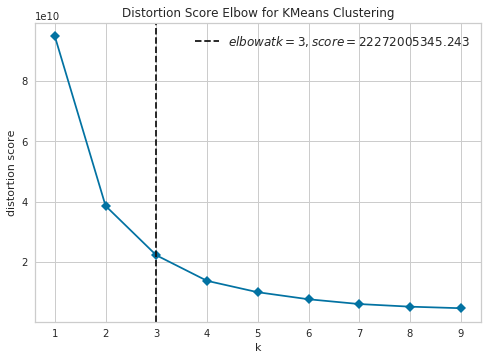

In [32]:
# find best k with Yellowbrick
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10), timings=False)

# Fit the data to the visualizer
visualizer.fit(rent_cluster)

visualizer.show()

In [33]:
# clustering with best k
kmeans = KMeans(n_clusters=3, random_state=0).fit(rent_cluster)

#check the labels
kmeans.labels_[0:10]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [34]:
# add clustering labels into final dataframe
dataset.insert(3, 'Cluster Labels', kmeans.labels_)
dataset.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  \
3822            Moema, SP   5000   2000               2   210 -23.601518   
6042  Jardim Paulista, SP   3800   1750               0   150 -23.573659   
2136      Barra Funda, SP   3000    844               0    66 -23.520024   
780           Cambuci, SP   1400    900               0    75 -23.572299   
1927         Perdizes, SP   2500    991               0   110 -23.533614   

      Longitude                            Cool places in district  
3822 -46.669156  Ice Cream Shop, Dessert Shop, Japanese Restaur...  
6042 -46.659471  Bakery, Pizza Place, Dessert Shop, Grocery Sto...  
2136 -46.675898  Brazilian Restaurant, Pizza Place, Restaurant,...  
780  -46.624270  Brazilian Restaurant, Restaurant, Farmers Mark...  
1927 -46.685849  Dessert Shop, Bar, Pizza Place, Bakery, Burger...

## Exploring clusters

I’ve found some interesting characteristics about each cluster. A breaf description of them are presented bellow.

### 1 - Small sizes and prices

This cluster have the smaller sizes (<100m²) and rent/condominium prices of apartments. It's also the bigger cluster, with more than 6000 places avaliable to rent in different districts. It's probably the first choice for most part of future renters.

In [35]:
# cluster labels = 0
cluster_0 = dataset.loc[dataset['Cluster Labels'] == 0]
cluster_0.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  \
5402   Casa Verde, SP   1150    400               0    60 -23.504735   
5706  Artur Alvim, SP   1100      0               0    49 -23.543748   
5395   Casa Verde, SP   1250    350               0    60 -23.504735   
4574        Limão, SP   1200    370               0    50   0.000000   
1821      Jaguaré, SP   1100    429               0    54 -23.543523   

      Longitude                            Cool places in district  
5402 -46.661028  Bar, Plaza, Gym / Fitness Center, Restaurant, ...  
5706 -46.481472  Bakery, Supermarket, Pizza Place, Ice Cream Sh...  
5395 -46.661028  Bar, Plaza, Gym / Fitness Center, Restaurant, ...  
4574   0.000000  Bar, Restaurant, Bakery, Music Venue, Burger J...  
1821 -46.752709  Brazilian Restaurant, Grocery Store, Food Truc...

In [46]:
#check max values for price and size
print('Smaller price rent: R$', cluster_0['Price'].min())
print('Most expensive rent: R$', cluster_0['Price'].max())
print('Smaller condominium price: R$', cluster_0['Condo'].min())
print('Most expensive condominium: R$', cluster_0['Condo'].max())
print('Apartments sizes range from', format(cluster_0['Size'].min()), 'to', format(cluster_0['Size'].max()), 'm²')
print('Mean size: ', format(cluster_0['Size'].mean(),'.0f'), 'm²')

Smaller price rent: R$ 480
Most expensive rent: R$ 4800
Smaller condominium price: R$ 0
Most expensive condominium: R$ 7500
Apartments sizes range from 30 to 400 m²
Mean size:  72 m²


In [37]:
cluster_0.shape

(6108, 8)

### 2 - A+ class

This is the most expensive and exclusive cluster of all. It has only 169 huge (>250m²) and really expensive apartments avaliable for rent. Ok, this is for the rich ones.

In [38]:
# cluster labels = 1
cluster_1 = dataset.loc[dataset['Cluster Labels'] == 1]
cluster_1.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  \
3208            Tatuapé, SP  16000   4800               1   425 -23.548995   
6946  Alto de Pinheiros, SP  16000   3500               1   280 -23.552010   
5509            Santana, SP  15000    900               1   296 -23.502112   
6902       Vila Mariana, SP  18000   1400               1   208 -23.591698   
4264  Alto de Pinheiros, SP  16000   2500               1   211 -23.561319   

      Longitude                            Cool places in district  
3208 -46.561935  Restaurant, Pizza Place, Bar, Brazilian Restau...  
6946 -46.710128  Plaza, Athletics & Sports, Restaurant, Bar, Co...  
5509 -46.635065  Pizza Place, Burger Joint, Japanese Restaurant...  
6902 -46.634107  Ice Cream Shop, Dessert Shop, Burger Joint, Ba...  
4264 -46.700173  Plaza, Athletics & Sports, Restaurant, Bar, Co...

In [47]:
#check max values for price and size
print('Smaller price rent: R$', cluster_1['Price'].min())
print('Most expensive rent: R$', cluster_1['Price'].max())
print('Smaller condominium price: R$', cluster_1['Condo'].min())
print('Most expensive condominium: R$', cluster_1['Condo'].max())
print('Apartments sizes range from', format(cluster_1['Size'].min()), 'to', format(cluster_1['Size'].max()), 'm²')
print('Mean size: ', format(cluster_1['Size'].mean(),'.0f'), 'm²')

Smaller price rent: R$ 13500
Most expensive rent: R$ 50000
Smaller condominium price: R$ 0
Most expensive condominium: R$ 8800
Apartments sizes range from 58 to 880 m²
Mean size:  285 m²


In [40]:
cluster_1.shape

(169, 8)

### 3 -  Big families

With high costs and apartments sizes (<150m²), future renters in this area must have a very good personal budget. It can be a good choice for people with many roommates or big families.

In [41]:
# cluster labels = 2
cluster_2 = dataset.loc[dataset['Cluster Labels'] == 2]
cluster_2.sample(5)

District  Price  Condo  Cluster Labels  Size   Latitude  \
6823        Morumbi, SP   4900   1980               2   200 -23.630539   
525         Tatuapé, SP   5990   1188               2   164 -23.530193   
1450   Vila Andrade, SP   4800   2408               2   243 -23.629570   
5991       Ipiranga, SP   7800   2500               2   283 -23.592062   
2560  Santa Cecília, SP   6000   4200               2   257 -23.542898   

      Longitude                            Cool places in district  
6823 -46.736279  Café, Soccer Stadium, Restaurant, Bakery, Coff...  
525  -46.577465  Restaurant, Pizza Place, Bar, Brazilian Restau...  
1450 -46.719437  Market, Pet Store, Pizza Place, Restaurant, Sh...  
5991 -46.607754  Brazilian Restaurant, Burger Joint, Bar, Snack...  
2560 -46.664151  Pizza Place, Italian Restaurant, Gym / Fitness...

In [48]:
#check max values for price and size
print('Smaller price rent: R$', cluster_2['Price'].min())
print('Most expensive rent: R$', cluster_2['Price'].max())
print('Smaller condominium price: R$', cluster_2['Condo'].min())
print('Most expensive condominium: R$', cluster_2['Condo'].max())
print('Apartments sizes range from', format(cluster_2['Size'].min()), 'to', format(cluster_2['Size'].max()), 'm²')
print('Mean size: ', format(cluster_2['Size'].mean(),'.0f'), 'm²')

Smaller price rent: R$ 4500
Most expensive rent: R$ 13350
Smaller condominium price: R$ 0
Most expensive condominium: R$ 9500
Apartments sizes range from 30 to 852 m²
Mean size:  168 m²


In [43]:
cluster_2.shape

(951, 8)

# Clustering visualization in São Paulo Map

All that places, big or small, cheap or expensive, are equaly distributed into districts, wich is expected since my clustering task didn't include location as a feature. So, it's important to note and remember that mos part of districts has avaliable apartments from diferent clusters, with means that they can suit diferent tipe of personal budgets and necessities. Here is a map visualization of that:

In [44]:
# get geocoordenates from São Paulo
url = 'https://maps.googleapis.com/maps/api/geocode/json'
g = geocoder.arcgis('São Paulo, BR')
g.latlng

[-23.562869999999975, -46.654679999999985]

In [45]:
import folium
import matplotlib.cm as cm
import matplotlib.colors as colors

# create map
map_clusters = folium.Map(location=g.latlng, zoom_start=13)

# set color scheme for the clusters
x = np.arange(3)
ys = [i + x + (i*x)**2 for i in range(3)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []

for lat, lon, poi, cluster in zip(dataset['Latitude'], dataset['Longitude'], dataset['District'], dataset['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
    [lat, lon],
    radius=5,
    popup=label,
    color=rainbow[cluster-1],
    fill=True,
    fill_color=rainbow[cluster-1],
    fill_opacity=0.7).add_to(map_clusters)

map_clusters

This is it. Feel free to comment and share your thoughts. Thanks.